In [1]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata, norm, pearsonr, chi2, t
from numpy.random import default_rng

# Carga Base
df = pd.read_csv(r"C:\\Users\\harc0\\Downloads\\datos_limpios.csv").dropna()
# Corrección de escala mencionada
df["total"] = df["total"] / 1000

# Construye matriz n x d: filas = (provincia, canton), columnas = tipologías (pérdidas agregadas)
pivot = df.pivot_table(index=['provincia','canton'], columns='tipologia', values='total', aggfunc='sum').fillna(0)
print(pivot.shape)
pivot.head()


(86, 22)


tipologia             ACTIVIDAD EMPRESARIAL  AERODROMOS  AGROPECUARIO  \
provincia canton                                                        
Alajuela  Alajuela                      0.0         0.0   7788017.707   
          Atenas                        0.0         0.0    371612.025   
          Grecia                        0.0         0.0    368550.115   
          Guatuso                       0.0         0.0   1639979.374   
          Los Chiles                 8650.0         0.0   8177307.504   

tipologia             ALCANTARILLAS Y VADOS    AMBIENTE    CARRETERAS  \
provincia canton                                                        
Alajuela  Alajuela                522500.00  31880410.0  5.843254e+06   
          Atenas                   16750.00         0.0  2.741950e+05   
          Grecia                       0.00         0.0  2.279721e+05   
          Guatuso                 308202.44         0.0  9.506459e+06   
          Los Chiles              276000.00         0.0  1.241053e+07   

tipologia             CENTROS EDUCATIVOS  DIVERSAS  EDIFICIOS PÚBLICOS  \
provincia canton                                                         
Alajuela  Alajuela           2367371.670       0.0          302137.000   
          Atenas                   0.000       0.0           26700.000   
          Grecia               76108.627       0.0          163000.000   
          Guatuso             124649.665       0.0          119816.502   
          Los Chiles               0.000       0.0           21415.000   

tipologia             ENERGÍA (POLIDUCTO)  ...  OBRAS DIVERSAS  \
provincia canton                           ...                   
Alajuela  Alajuela                    0.0  ...             0.0   
          Atenas                      0.0  ...             0.0   
          Grecia                      0.0  ...             0.0   
          Guatuso                     0.0  ...             0.0   
          Los Chiles                  0.0  ...             0.0   

tipologia             PRIMER IMPACTO      PUENTES  RÍOS Y QUEBRADAS  \
provincia canton                                                      
Alajuela  Alajuela        189237.394  2783641.000          514382.0   
          Atenas           63543.344    51355.000             500.0   
          Grecia           21033.340  1465066.012               0.0   
          Guatuso         323381.058  2634605.000         6583000.0   
          Los Chiles      323312.500  8262617.000         2027000.0   

tipologia             SISTEMAS DE AGUA  SISTEMAS DE INFOCOMUNICACIONES  \
provincia canton                                                         
Alajuela  Alajuela          687532.372                       90171.000   
          Atenas            178117.610                           0.000   
          Grecia            118269.372                           0.000   
          Guatuso            35991.995                       45473.875   
          Los Chiles       1022953.295                           0.000   

tipologia             SISTEMAS DE RIEGO  SISTEMAS ELÉCTRICOS      SOCIAL  \
provincia canton                                                           
Alajuela  Alajuela                  0.0          205427820.0       0.000   
          Atenas                    0.0                  0.0       0.000   
          Grecia                    0.0                  0.0       0.000   
          Guatuso                   0.0               6700.0  304375.591   
          Los Chiles                0.0               2400.0     497.594   

tipologia               VIVIENDA  
provincia canton                  
Alajuela  Alajuela    13006730.0  
          Atenas        834552.5  
          Grecia       1095970.0  
          Guatuso      2334000.0  
          Los Chiles     40000.0  

[5 rows x 22 columns]

Para dejar los datos listos para análisis multivariado y construcción de copulas.

Se resume la suma de cada tipología por cantón usando una tabla pivote (pivot_table en Python o pivot_wider en R)

In [2]:
# CDF empírica por rangos con corrección (evita 0/1 exactos)
def to_uniform(x):
    r = rankdata(x, method='average')
    return (r - 0.5) / len(r)

# U en (0,1) por columna (tipología)
pivot_uniform = pivot.apply(to_uniform, axis=0)

# Z = normal scores = Phi^{-1}(U)
pivot_normal = pivot_uniform.apply(lambda u: norm.ppf(u), axis=0)

# Guarda nombres de tipologías
tipos = pivot.columns.tolist()

In [3]:
Z = pivot_normal.dropna(axis=0, how='any').to_numpy()
_, d = Z.shape

# Estadístico observado
R = np.corrcoef(Z, rowvar=False)
upper = np.triu_indices(d, k=1)
S_obs = np.sum(R[upper]**2)

# Permutaciones 
B = 2000
rng = default_rng(12345)
S_perm = np.empty(B)
for b in range(B):
    Zp = np.vstack([rng.permutation(Z[:, j]) for j in range(d)]).T
    Rp = np.corrcoef(Zp, rowvar=False)
    S_perm[b] = np.sum(Rp[upper]**2)

pval = (1 + np.sum(S_perm >= S_obs)) / (1 + B)
print(f'd={d}, S_obs={S_obs:.4f}, p-valor global={pval:.4g}')
print('Decisión (α=0.05):', 'Rechazar H0 (dependencia multivariada)' if pval < 0.05 else 'No rechazar H0 (independencia)')

d=22, S_obs=29.9503, p-valor global=0.0004998
Decisión (α=0.05): Rechazar H0 (dependencia multivariada)


Test global de independencia (22 tipologías)
Se realizó un test global de independencia multivariada utilizando la suma de las correlaciones cuadradas.
Valor observado del estadístico: S=29.95

p-valor calculado: 0.0005

Como el p-valor es menor que el nivel de significancia (α = 0.05), se rechaza la hipótesis nula de independencia multivariada.

Conclusión: Existe dependencia significativa entre las tipologías de desastres



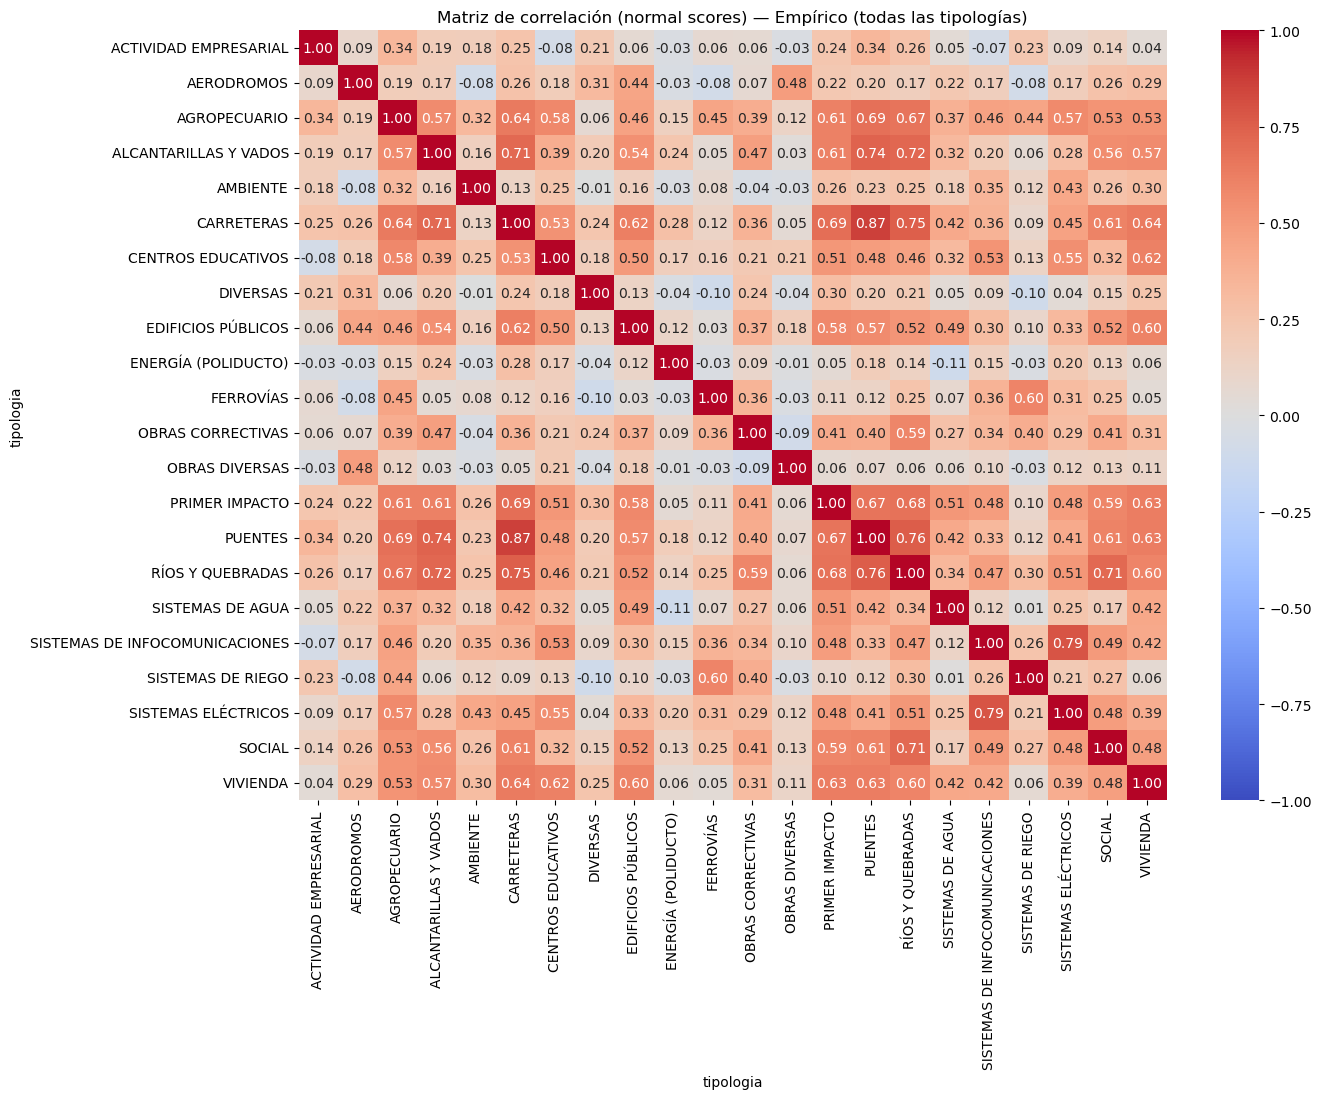

In [4]:
# Matriz de correlación Pearson sobre Z (normal scores)
R_emp = pivot_normal.corr(method='pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(R_emp, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación (normal scores) — Empírico (todas las tipologías)')
plt.show()

Esta matriz muestra la correlación empírica entre las diferentes tipologías de pérdidas, transformadas a normal scores para eliminar el efecto de escala. Los valores elevados (rojos) indican tipologías que tienden a experimentar pérdidas altas de manera conjunta, mientras que valores cercanos a cero señalan independencia. Es evidente que ciertos grupos de infraestructura (por ejemplo, carreteras, puentes y ríos) presentan dependencias destacadas, lo que sugiere relaciones estructurales o efectos compartidos por eventos extremos.

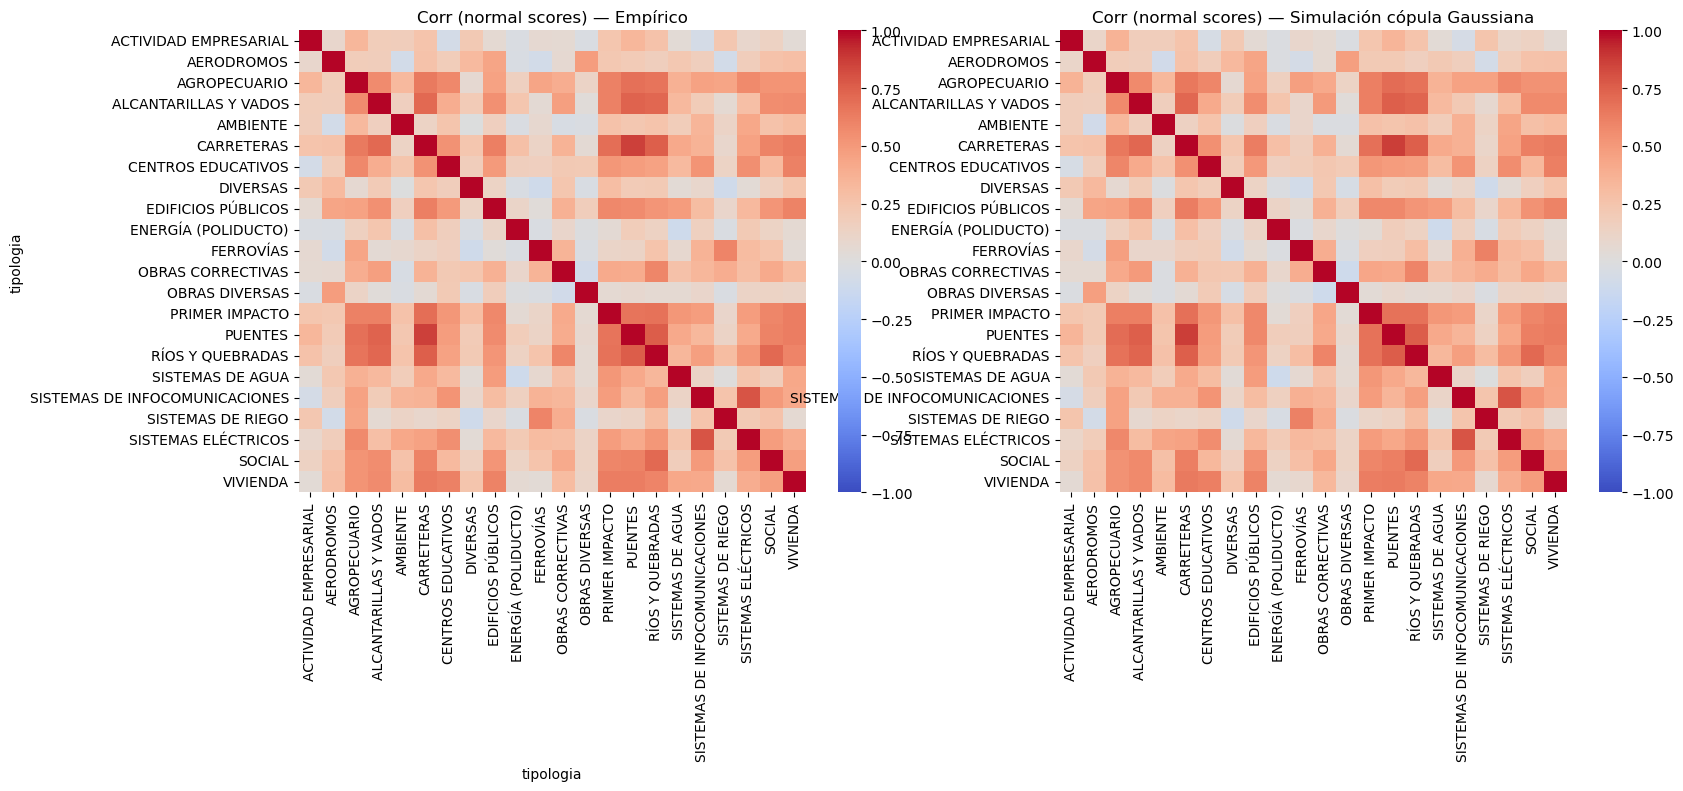

In [5]:
R_hat = R_emp.values

# Simulación
rng = default_rng(2025)
nsim = 5000
Zsim = rng.multivariate_normal(mean=np.zeros(len(tipos)), cov=R_hat, size=nsim)
Usim_gauss = norm.cdf(Zsim)

# DataFrames simulados
df_Zsim = pd.DataFrame(Zsim, columns=tipos)
df_Usim_gauss = pd.DataFrame(Usim_gauss, columns=tipos)

# Correlación simulada en Z 
R_sim = df_Zsim.corr()

fig, axes = plt.subplots(1, 2, figsize=(18,6))
sns.heatmap(R_emp, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Corr (normal scores) — Empírico')
sns.heatmap(R_sim, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1)
axes[1].set_title('Corr (normal scores) — Simulación cópula Gaussiana')
plt.show()

La matriz de la izquierda muestra las correlaciones observadas entre normal scores de tipologías (dependencia empírica real), mientras que la de la derecha refleja las correlaciones generadas por la simulación de la cópula gaussiana ajustada.

Ambas matrices exhiben patrones muy similares: los pares de tipologías con alta correlación empírica mantienen valores elevados en la simulación, lo que indica que la cópula gaussiana reproduce adecuadamente la dependencia lineal observada en los datos. Pequeñas diferencias pueden aparecer en algunos pares, pero globalmente el modelo logra capturar la estructura de dependencia multivariada del sistema.

In [6]:
# Top-k pares por |rho| empírico
k = 12
pairs = []
for i in range(len(tipos)):
    for j in range(i+1, len(tipos)):
        pairs.append((tipos[i], tipos[j], R_emp.iloc[i,j]))

top_pairs = sorted(pairs, key=lambda t: abs(t[2]), reverse=True)[:k]
pd.DataFrame(top_pairs, columns=['Tipología 1','Tipología 2','rho_emp']).style.format({'rho_emp':'{:.3f}'})

,Tipología 1,Tipología 2,rho_emp
0,CARRETERAS,PUENTES,0.866
1,SISTEMAS DE INFOCOMUNICACIONES,SISTEMAS ELÉCTRICOS,0.794
2,PUENTES,RÍOS Y QUEBRADAS,0.762
3,CARRETERAS,RÍOS Y QUEBRADAS,0.751
4,ALCANTARILLAS Y VADOS,PUENTES,0.742
5,ALCANTARILLAS Y VADOS,RÍOS Y QUEBRADAS,0.724
6,ALCANTARILLAS Y VADOS,CARRETERAS,0.715
7,RÍOS Y QUEBRADAS,SOCIAL,0.713
8,CARRETERAS,PRIMER IMPACTO,0.689
9,AGROPECUARIO,PUENTES,0.687


Esta tabla resume los pares de tipologías con mayor correlación empírica. Los valores altos de rho indican que esas tipologías tienden a presentar pérdidas elevadas de forma conjunta.

In [9]:
# Función para calcular la proporción de co-extremos
def coext(dfU, col_i, col_j, q):
    u1, u2 = dfU[col_i].to_numpy(), dfU[col_j].to_numpy()
    return np.mean((u1 > q) & (u2 > q))
    
# Selecciona el par ancla (el de mayor |rho| empírico)
i0, j0, rho0 = top_pairs[0]

# Función de pérdida para calibrar nu
def loss_nu(nu_try, q=0.95, nsim=4000):
    R2 = np.array([[1, rho0],[rho0, 1]])
    Zb = rng.multivariate_normal([0,0], R2, size=nsim)
    Wb = chi2.rvs(df=nu_try, size=nsim, random_state=rng) / nu_try
    Tb = Zb / np.sqrt(Wb)[:, None]
    Ub = t.cdf(Tb, df=nu_try)
    emp = coext(pivot_uniform[[i0,j0]], i0, j0, q)
    sim = np.mean((Ub[:,0] > q) & (Ub[:,1] > q))
    return (sim - emp)**2

# Barrido de nu y selección óptima
nus = [3,4,5,6,8,10,15,20,30]
errs = [loss_nu(nu_try) for nu_try in nus]
nu_best = nus[int(np.argmin(errs))]
print(f"nu óptimo para matching de co-extremos en el par {i0}-{j0}: {nu_best}")

# Simulación multivariada t-cópula
Zt = rng.multivariate_normal(mean=np.zeros(len(tipos)), cov=R_hat, size=nsim)
W = chi2.rvs(df=nu_best, size=nsim, random_state=rng) / nu_best
Tvals = Zt / np.sqrt(W)[:, None]
Usim_t = t.cdf(Tvals, df=nu_best)
df_Usim_t = pd.DataFrame(Usim_t, columns=tipos)

# Tabla comparativa de co-extremos 
rows = []
for i,j,rho in top_pairs:
    emp_95 = coext(pivot_uniform, i, j, 0.95)
    gau_95 = coext(df_Usim_gauss, i, j, 0.95)
    t_95   = coext(df_Usim_t,    i, j, 0.95)
    emp_99 = coext(pivot_uniform, i, j, 0.99)
    gau_99 = coext(df_Usim_gauss, i, j, 0.99)
    t_99   = coext(df_Usim_t,    i, j, 0.99)
    rows.append([i,j,rho, emp_95,gau_95,t_95, emp_99,gau_99,t_99])

cols = ['Tipología 1','Tipología 2','rho_emp',
        'Emp P>0.95','Gauss P>0.95',f't(ν={nu_best}) P>0.95',
        'Emp P>0.99','Gauss P>0.99',f't(ν={nu_best}) P>0.99']
comp_df = pd.DataFrame(rows, columns=cols)
comp_df.sort_values('rho_emp', key=lambda s: s.abs(), ascending=False).style.format({
    'rho_emp':'{:.3f}',
    'Emp P>0.95':'{:.4f}', 'Gauss P>0.95':'{:.4f}', f't(ν={nu_best}) P>0.95':'{:.4f}',
    'Emp P>0.99':'{:.5f}', 'Gauss P>0.99':'{:.5f}', f't(ν={nu_best}) P>0.99':'{:.5f}'
})


nu óptimo para matching de co-extremos en el par CARRETERAS-PUENTES: 15


,Tipología 1,Tipología 2,rho_emp,Emp P>0.95,Gauss P>0.95,t(ν=15) P>0.95,Emp P>0.99,Gauss P>0.99,t(ν=15) P>0.99
0,CARRETERAS,PUENTES,0.866,0.0116,0.0310,0.0306,0.00000,0.00540,0.00520
1,SISTEMAS DE INFOCOMUNICACIONES,SISTEMAS ELÉCTRICOS,0.794,0.0349,0.0260,0.0278,0.01163,0.00360,0.00440
2,PUENTES,RÍOS Y QUEBRADAS,0.762,0.0116,0.0258,0.0236,0.00000,0.00360,0.00320
3,CARRETERAS,RÍOS Y QUEBRADAS,0.751,0.0000,0.0230,0.0218,0.00000,0.00360,0.00300
4,ALCANTARILLAS Y VADOS,PUENTES,0.742,0.0233,0.0194,0.0232,0.00000,0.00340,0.00360
5,ALCANTARILLAS Y VADOS,RÍOS Y QUEBRADAS,0.724,0.0116,0.0208,0.0232,0.01163,0.00300,0.00360
6,ALCANTARILLAS Y VADOS,CARRETERAS,0.715,0.0349,0.0208,0.0198,0.00000,0.00280,0.00320
7,RÍOS Y QUEBRADAS,SOCIAL,0.713,0.0116,0.0208,0.0212,0.00000,0.00420,0.00260
8,CARRETERAS,PRIMER IMPACTO,0.689,0.0000,0.0206,0.0208,0.00000,0.00320,0.00280
9,AGROPECUARIO,PUENTES,0.687,0.0116,0.0208,0.0196,0.00000,0.00360,0.00280


La tabla compara la probabilidad de observar pérdidas extremas conjuntas (por encima del percentil 95 y 99) entre los pares más dependientes de tipologías, en tres escenarios: datos empíricos, simulación con cópula gaussiana y simulación con t-cópula (ν = 8).